# 02 — Tiền xử lý & Tạo đặc trưng (Airbnb NYC 2019)

**Mục tiêu**  
- Làm sạch dữ liệu thô (tọa độ, giá trị thiếu, outlier)  
- Chuẩn hóa cột số, mã hóa biến phân loại cơ bản
- Gói dữ liệu đã xử lý thành `X, y` để modeling ở bước sau, lưu `.npz`

**Lưu ý về file CSV**: file có nhiều chuỗi chứa dấu phẩy trong dấu ngoặc kép (`"..."`), cần parser CSV chuẩn (RFC4180) => Python `csv` module xử lý đúng `quotechar="\""`

## 1) Khởi tạo & import

In [1]:
# Xác định ROOT sao cho linh hoạt khi mở notebook từ project 
from pathlib import Path
import sys

ROOT = Path.cwd()
if not (ROOT / "src").exists() and (ROOT.parent / "src").exists():
    ROOT = ROOT.parent

print(ROOT)
sys.path.insert(0, str(ROOT))

/home/khoaoe/ds_programming/lab/lab02/airbnb


In [2]:
import numpy as np
from IPython import display

# Import các API trong src/__init__.py
from src import (
    # I/O & summarize
    load_airbnb, missing_summary, unique_summary, describe_numeric,
    numeric_cols, categorical_cols,
    # Preprocess
    preprocess_airbnb_default,   
    assemble_features_airbnb,assemble_features_airbnb_plus_geo,
    save_processed_npz, 
    # Visualization
    plot_hist_with_quantiles, plot_corr_heatmap, corr_matrix
)

In [3]:
# data paths
DATA_RAW = ROOT / "data" / "raw"
DATA_PROCESSED = ROOT / "data" / "processed"
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
# output .npz path
OUT_NPZ = DATA_PROCESSED / "ab_nyc_2019_processed.npz"

## 2) Load dữ liệu 
- Dùng loader NumPy-only dựa trên `csv.DictReader` 
- Trả về dict: {column -> np.ndarray}

In [4]:
cols_raw = load_airbnb(str(DATA_RAW))
n_rows = len(next(iter(cols_raw.values())))

print(f"Số dòng: {n_rows}")
print("Các cột:", list(cols_raw.keys()))

Số dòng: 48895
Các cột: ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


## 3) Tóm tắt về thiếu dữ liệu & thống kê số

In [5]:
miss = missing_summary(cols_raw)
miss_sorted = miss[np.argsort(-miss["missing_rate_%"])]
miss_sorted

array([('last_review', 10052, 20.5583393 ),
       ('reviews_per_month', 10052, 20.5583393 ),
       ('host_name',    21,  0.04294918), ('name',    16,  0.03272318),
       ('id',     0,  0.        ), ('host_id',     0,  0.        ),
       ('neighbourhood_group',     0,  0.        ),
       ('neighbourhood',     0,  0.        ),
       ('latitude',     0,  0.        ),
       ('longitude',     0,  0.        ),
       ('room_type',     0,  0.        ), ('price',     0,  0.        ),
       ('minimum_nights',     0,  0.        ),
       ('number_of_reviews',     0,  0.        ),
       ('calculated_host_listings_count',     0,  0.        ),
       ('availability_365',     0,  0.        )],
      dtype=[('column', '<U50'), ('missing_count', '<i8'), ('missing_rate_%', '<f8')])

In [6]:
desc_num = describe_numeric(cols_raw, numeric_cols)
desc_num

array([('id',  2.539000e+03,  9.471945e+06,  1.9677284e+07,  2.91521785e+07,  3.64872450e+07,  1.90171432e+07, 1.09831084e+07),
       ('host_id',  2.438000e+03,  7.822033e+06,  3.0793816e+07,  1.07434423e+08,  2.74321313e+08,  6.76200106e+07, 7.86109670e+07),
       ('latitude',  4.049979e+01,  4.069010e+01,  4.0723070e+01,  4.07631150e+01,  4.09130600e+01,  4.07289489e+01, 5.45300781e-02),
       ('longitude', -7.424442e+01, -7.398307e+01, -7.3955680e+01, -7.39362750e+01, -7.37129900e+01, -7.39521696e+01, 4.61567361e-02),
       ('price',  0.000000e+00,  6.900000e+01,  1.0600000e+02,  1.75000000e+02,  1.00000000e+04,  1.52720687e+02, 2.40154170e+02),
       ('minimum_nights',  1.000000e+00,  1.000000e+00,  3.0000000e+00,  5.00000000e+00,  1.25000000e+03,  7.02996216e+00, 2.05105495e+01),
       ('number_of_reviews',  0.000000e+00,  1.000000e+00,  5.0000000e+00,  2.40000000e+01,  6.29000000e+02,  2.32744657e+01, 4.45505823e+01),
       ('reviews_per_month',  1.000000e-02,  1.900000e-0

In [7]:
uniq_cat = unique_summary(cols_raw, categorical_cols)
uniq_cat

array([('name', 47895, 9.79548011e+01),
       ('host_name', 11453, 2.34236630e+01),
       ('neighbourhood_group',     5, 1.02259945e-02),
       ('neighbourhood',   221, 4.51988956e-01),
       ('room_type',     3, 6.13559669e-03)],
      dtype=[('column', '<U50'), ('unique_count', '<i8'), ('unique_rate_%', '<f8')])

## 4) Tiền xử lý
Pipeline tiền xử lý gồm:
- Lọc toạ độ ngoài vùng NYC (theo plot địa lý cơ bản) 
- `reviews_per_month = 0` nếu `number_of_reviews == 0` (chưa từng có review)  
- Impute median cho các cột số còn thiếu

In [8]:
# Về toạ độ NYC: NYC nằm quanh (~) (40.714, -74.006) và các borough bao phủ vùng lân cận; lọc theo city extent giúp loại điểm outlier địa lý có thể thấy rõ
# Về logic reviews_per_month: nhiều phân tích thực hành thay NaN bằng 0 khi chưa từng có review (hợp ngữ nghĩa)
cols_clean, report = preprocess_airbnb_default(cols_raw, geo_filter=True)

print("Tỷ lệ giữ sau lọc geo:", round(report.get("kept_geo_ratio", 1.0), 4))
print("Impute median:", report.get("median_imputed", {}))

Tỷ lệ giữ sau lọc geo: 0.9996
Impute median: {}


## 5) Visualize phân phối `price`
- Dữ liệu có tail nặng (căn hộ giá cực cao); winsorize nhẹ giúp mô hình ổn định hơn
- Mức mặc định: clip theo [1, 99] percentile (có thể tinh chỉnh trong notebook modeling)


Visualize phân phối price (raw)


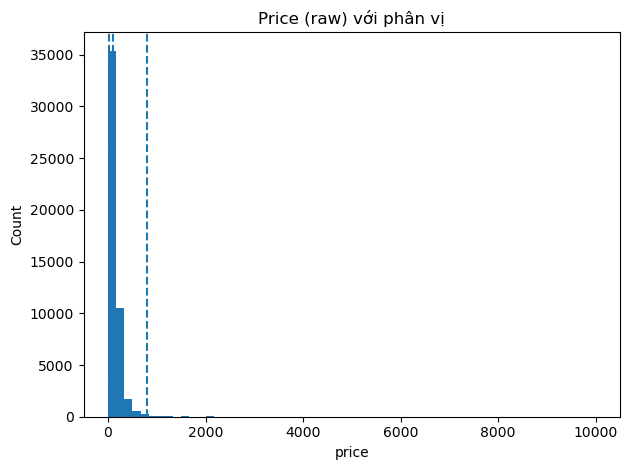

In [9]:
price_raw = cols_raw["price"].astype(float)

print("Visualize phân phối price (raw)")
plot_hist_with_quantiles(price_raw, qs=(1,50,99), bins=60, title="Price (raw) với phân vị", xlabel="price")

Visualize phân phối price (clean)


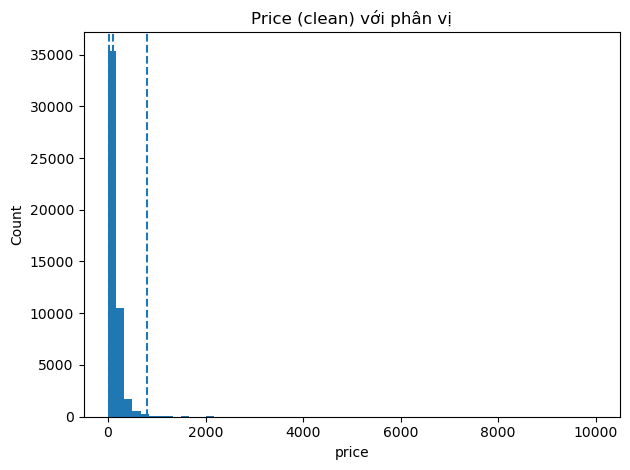

In [10]:
price_clean = cols_clean["price"].astype(float)

print("Visualize phân phối price (clean)")
plot_hist_with_quantiles(price_clean, qs=(1,50,99), bins=60, title="Price (clean) với phân vị", xlabel="price")

## 6) Tạo feature `X` và biến mục tiêu `y` cho modeling
- Numeric: `latitude, longitude, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count, availability_365, ...`
- Categorical (one-hot, gộp nhãn hiếm): `neighbourhood_group, room_type, neighbourhood, geo_cluster`
- Target: `price` (clip [1, 99] percentile)

In [11]:
# X, y, feat_names, encoders = assemble_features_airbnb(cols_clean)

# print("Kích thước tập đặc trưng X, y:", X.shape, y.shape)
# print("Số đặc trưng:", len(feat_names))

### (Optional) Thêm feature về mặt địa lý 
- K-means clustering trên toạ độ (`latitude, longitude`) để tạo các cụm vùng địa lý
- Mã hoá one-hot cluster theo địa lý, thêm vào `X`

In [12]:
X, y, feat_names, encoders = assemble_features_airbnb_plus_geo(
    cols_clean,
    cat_cols=("neighbourhood_group","room_type","neighbourhood"),
    cat_min_count=10,
    k_geo=8,  # số cụm, có thể thử 6 -> 12
)

print("Kích thước tập đặc trưng X, y:", X.shape, y.shape)
print("Số đặc trưng:", len(feat_names))

Kích thước tập đặc trưng X, y: (48877, 199) (48877,)
Số đặc trưng: 199


In [13]:
print("Tên cột features:")
print(feat_names)

Tên cột features:
['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'neighbourhood_group=Bronx', 'neighbourhood_group=Brooklyn', 'neighbourhood_group=Manhattan', 'neighbourhood_group=Queens', 'neighbourhood_group=Staten Island', 'room_type=Entire home/apt', 'room_type=Private room', 'room_type=Shared room', 'neighbourhood=Allerton', 'neighbourhood=Arrochar', 'neighbourhood=Arverne', 'neighbourhood=Astoria', 'neighbourhood=Bath Beach', 'neighbourhood=Battery Park City', 'neighbourhood=Bay Ridge', 'neighbourhood=Bayside', 'neighbourhood=Bayswater', 'neighbourhood=Bedford-Stuyvesant', 'neighbourhood=Bellerose', 'neighbourhood=Belmont', 'neighbourhood=Bensonhurst', 'neighbourhood=Bergen Beach', 'neighbourhood=Boerum Hill', 'neighbourhood=Borough Park', 'neighbourhood=Briarwood', 'neighbourhood=Brighton Beach', 'neighbourhood=Bronxdale', 'neighbourhood=Brooklyn Heights', 'neighbourhood=Brownsville', 'n

In [14]:
print("Thông tin các feature từ encoder:")
for c, mp in encoders.items():
    print(f"- {c}: {len(mp)} nhãn")

Thông tin các feature từ encoder:
- neighbourhood_group: 5 nhãn
- room_type: 3 nhãn
- neighbourhood: 168 nhãn
- geo_cluster: 8 nhãn


## 7) Tương quan giữa các cột số + price

Using seaborn for heatmap visualization


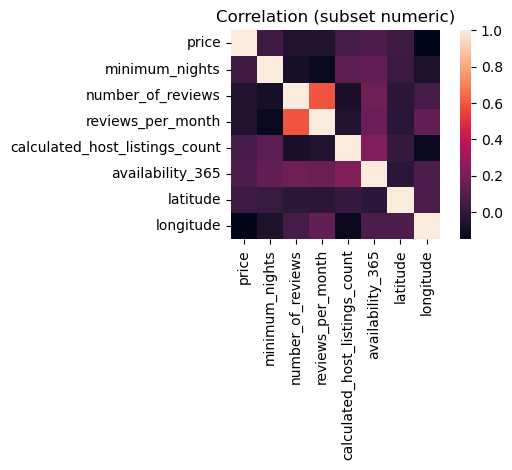

In [15]:
num_col_for_corr = [
    "price", "minimum_nights", "number_of_reviews", "reviews_per_month",
    "calculated_host_listings_count", "availability_365", "latitude", "longitude"
]
C, labels = corr_matrix(cols_clean, num_col_for_corr)

plot_corr_heatmap(C, labels, title="Correlation (subset numeric)")

## 8) Lưu dữ liệu đã xử lý
Lưu `X, y, feature_names, encoders, meta(report)` vào file `.npz` để dùng cho notebook modeling


In [16]:
meta = {
    "kept_geo_ratio": report.get("kept_geo_ratio"),
    "median_imputed": report.get("median_imputed"),
    "note": "clip target [1,99] pct; one-hot cat; impute median for numeric."
}

save_processed_npz(
    str(OUT_NPZ),
    X=X, y=y,
    feature_names=feat_names,
    encoders=encoders,
    meta=meta
)
print(f"Đã lưu file .npz vào: {OUT_NPZ.resolve()}")

Đã lưu file .npz vào: /home/khoaoe/ds_programming/lab/lab02/airbnb/data/processed/ab_nyc_2019_processed.npz


In [17]:
# Sanity check 
check = np.load(OUT_NPZ, allow_pickle=True)

print("Keys:", list(check.keys()))
print("X:", check["X"].shape, "y:", check["y"].shape)
print("feature_names:", check["feature_names"].shape)

Keys: ['X', 'y', 'feature_names', 'encoders', 'meta']
X: (48877, 199) y: (48877,)
feature_names: (199,)
